In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

In [7]:
#load some data
data = np.loadtxt('../data/processed/REST1fMRI_SchaeferTian116_GSR/100206_rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean_timeseries.csv', delimiter=',')
import h5py as h5
with h5.File('../data/processed/REST1REST2fMRI_SchaeferTian116_GSR.h5', 'r') as f:
    data_all = f['timeseries_train'][:,:,0]

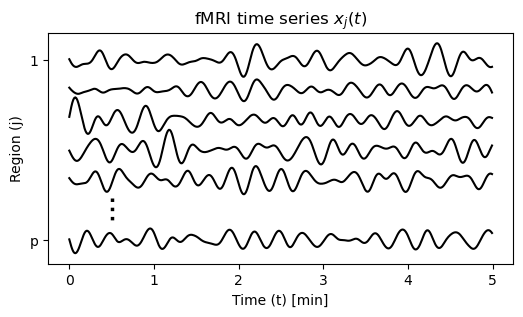

In [8]:
#plot the first 5 signals on top of each other, then some space and a sixth signal
data = (data - np.mean(data, axis=0))/np.std(data, axis=0)
time_axis = np.arange(data.shape[0])/(60*(1/0.720))
num_timepoints = 417
plt.figure(figsize=(6, 3))
plt.plot(time_axis[:num_timepoints],data[:num_timepoints,:5]+5*np.arange(5),color='black')
plt.plot(time_axis[:num_timepoints],data[:num_timepoints,5]-10,color='black')
plt.yticks([20,-10],['1','p']);
plt.ylabel('Region (j)')
plt.xlabel('Time (t) [min]')
#add a vertical dotdotdot between the two groups of signals
plt.plot([0.5,0.5],[-3,-7],color='black',linestyle=':',linewidth=2.5)
plt.title(r'fMRI time series $x_j(t)$');
plt.savefig('figures/fmri_ts_example.pdf', bbox_inches='tight')

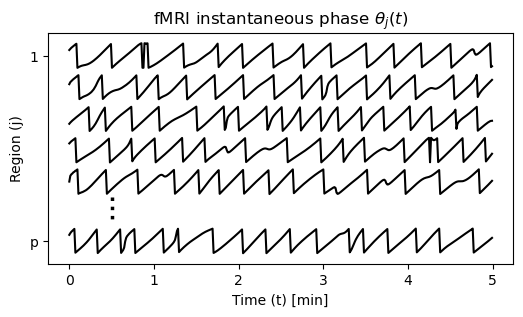

In [9]:
# Do the same as above but with hilbert phases
# analytic_signal = data + 1j * hilbert(data.T).T
analytic_signal = hilbert(data.T).T
phase_data = np.exp(1j * np.angle(analytic_signal))/np.sqrt(116)

plt.figure(figsize=(6, 3))
plt.plot(time_axis[:num_timepoints],np.angle(phase_data[:num_timepoints,:5])+8*np.arange(5),color='black')
plt.plot(time_axis[:num_timepoints],np.angle(phase_data[:num_timepoints,5])-15,color='black')
plt.yticks([8*4,-15],['1','p']);
plt.ylabel('Region (j)')
plt.xlabel('Time (t) [min]')
#add a vertical dotdotdot between the two groups of signals
plt.plot([0.5,0.5],[-4,-10],color='black',linestyle=':',linewidth=2.5)
plt.title(r'fMRI instantaneous phase $\theta_j(t)$');
plt.savefig('figures/fmri_phase_example.pdf', bbox_inches='tight')

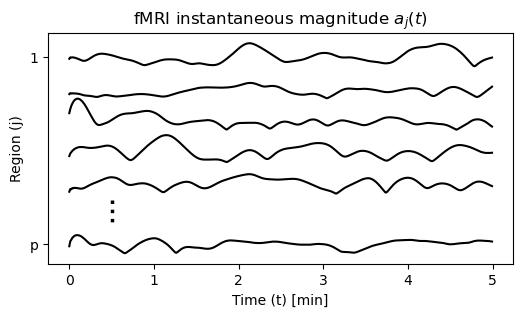

In [10]:
# Do the same as above but with hilbert phases
magntiude_data = (np.abs(analytic_signal)-np.mean(np.abs(analytic_signal), axis=0))*2

plt.figure(figsize=(6, 3))
plt.plot(time_axis[:num_timepoints],magntiude_data[:num_timepoints,:5]+8*np.arange(5),color='black')
plt.plot(time_axis[:num_timepoints],magntiude_data[:num_timepoints,5]-15,color='black')
plt.yticks([8*4,-15],['1','p']);
plt.ylabel('Region (j)')
plt.xlabel('Time (t) [min]')
#add a vertical dotdotdot between the two groups of signals
plt.plot([0.5,0.5],[-4,-10],color='black',linestyle=':',linewidth=2.5)
plt.title(r'fMRI instantaneous magnitude $a_j(t)$');
plt.savefig('figures/fmri_magnitude_example.pdf', bbox_inches='tight')

(0.0, 0.1)

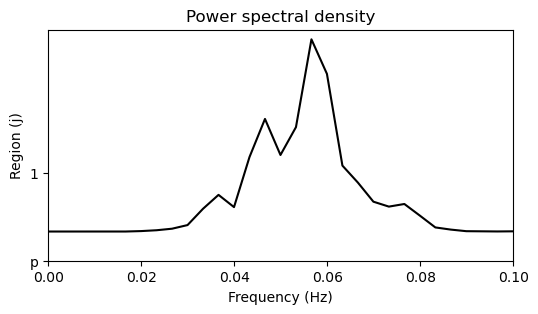

In [11]:
# plot the frequency spectrum of data (after filtering)
from scipy.signal import welch
f, Pxx = welch(data.T, fs=1/0.720, nperseg=417)
plt.figure(figsize=(6, 3))
plt.plot(f, Pxx[0],color='black')
# plt.plot(f, Pxx[5,:]-10,color='black')
plt.yticks([20,-10],['1','p']);
plt.ylabel('Region (j)')
plt.xlabel('Frequency (Hz)')
plt.title('Power spectral density');
plt.xlim([0,0.1])

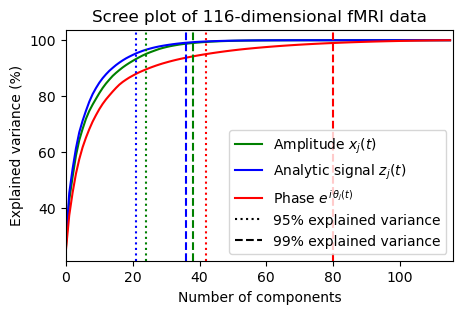

In [12]:
# make a scree plot of the filtered data for all regions
from scipy.signal import butter, filtfilt
filtered_data = np.zeros_like(data)
lp_freq = 0.03
hp_freq = 0.07
for i in range(data.shape[1]):
    b, a = butter(2, [lp_freq, hp_freq], btype='band')
    filtered_data[:,i] = filtfilt(b, a, data[:,i]-np.mean(data[:,i]))

GS = np.mean(filtered_data, axis=1)
filtered_data = filtered_data - GS[:,None]*(filtered_data.T@GS).T/(GS.T@GS)

# filtered_data = data_all

# compute analytic signal
analytic_signal = filtered_data + 1j * hilbert(filtered_data.T).T
phase_data = np.exp(1j * np.angle(analytic_signal))/np.sqrt(116)

# # do pca
# from sklearn.decomposition import PCA
# pca1 = PCA()
# pca1.fit(filtered_data)
# pca2 = PCA()
# pca2.fit(analytic_signal)
# pca3 = PCA()
# pca3.fit(phase_data)

# do the same with the svd
S1 = np.linalg.svd(filtered_data, full_matrices=False, compute_uv=False)
S1_scree = np.cumsum(S1**2)/np.sum(S1**2)*100
S2 = np.linalg.svd(analytic_signal, full_matrices=False, compute_uv=False)
S2_scree = np.cumsum(S2**2)/np.sum(S2**2)*100
S3 = np.linalg.svd(phase_data, full_matrices=False, compute_uv=False)
S3_scree = np.cumsum(S3**2)/np.sum(S3**2)*100


plt.figure(figsize=(5, 3))
plt.plot(S1_scree,color='green')
plt.plot(S2_scree,color='blue')
plt.plot(S3_scree,color='red')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.xlim([0, 116])
# add a vertical line at 95% and 99% including text
p95_1 = np.argmax(S1_scree > 95)
p95_2 = np.argmax(S2_scree > 95)
p95_3 = np.argmax(S3_scree > 95)
p99_1 = np.argmax(S1_scree > 99)
p99_2 = np.argmax(S2_scree > 99)
p99_3 = np.argmax(S3_scree > 99)
plt.axvline(p95_1, color='green', linestyle=':', linewidth=1.5)
plt.axvline(p95_2, color='blue', linestyle=':', linewidth=1.5)
plt.axvline(p95_3, color='red', linestyle=':', linewidth=1.5)
plt.axvline(p99_1, color='green', linestyle='--', linewidth=1.5)
plt.axvline(p99_2, color='blue', linestyle='--', linewidth=1.5)
plt.axvline(p99_3, color='red', linestyle='--', linewidth=1.5)
# p95 = np.argmax(np.cumsum(pca1.explained_variance_ratio_)*100 > 95)
# p99 = np.argmax(np.cumsum(pca1.explained_variance_ratio_)*100 > 99)
# plt.axvline(p95, color='black', linestyle=':', linewidth=2.5)
# plt.axvline(p99, color='black', linestyle=':', linewidth=2.5)
# plt.text(p95+5, 90, '95%', ha='center', va='center', color='black')
# plt.text(p99+5, 90, '99%', ha='center', va='center', color='black')
# plt.text(50, 99, '99%', ha='center', va='center', color='black')
plt.legend([plt.plot([],color='green')[0], plt.plot([],color='blue')[0], plt.plot([],color='red')[0], plt.plot([],color='black',linestyle=':')[0], plt.plot([],color='black',linestyle='--')[0]], 
           [r'Amplitude $x_j(t)$', r'Analytic signal $z_j(t)$', r'Phase $e^{i\,\theta_j(t)}$', r'95% explained variance', r'99% explained variance'])

# plt.legend([r'Amplitude $x_j(t)$', r'Analytic signal $z_j(t)$', r'Phase $e^{i\,\theta_j(t)}$'])
plt.title('Scree plot of 116-dimensional fMRI data');
plt.savefig('figures/scree_plot.pdf', bbox_inches='tight')

# Below is unused

Text(0.5, 0, 'Time')

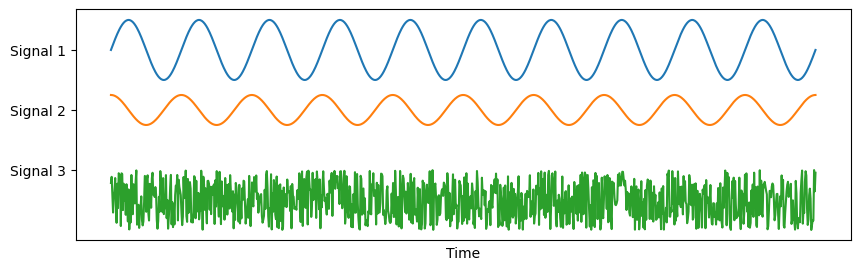

In [13]:
# generate three, equal length signals, each with 1000 points
# The first signal is a sine wave with amplitude 1 and frequency 1 Hz
# The second signal is the same as signal 1 albeit phase shifted by pi/2 and with amplitude 0.5
# The third signal is a random signal uncorrelated to the first two. 
# Then plot the three signals in a wide, narrow figure

num_samples = 1000
frequency = 10
t = np.linspace(0, 1, num_samples)
s1 = np.sin(frequency * 2 * np.pi * t)
s2 = 0.5 * np.sin(frequency * 2 * np.pi * t + np.pi/2)
s3 = np.random.rand(num_samples)*2 - 1
data = np.vstack([s1, s2, s3])

plt.figure(figsize=(10, 3))
plt.plot(t, s1+5, label='s1')
plt.plot(t, s2+3, label='s2')
plt.plot(t, s3, label='s3')
plt.yticks([1,3,5], ['Signal 3', 'Signal 2', 'Signal 1']);
plt.xticks([])
plt.xlabel('Time')

Waiting for a good least squares initialization
Found a good initialization
Initializing Psi based on the clustering centroids
Beginning EM loop


Loglik: -2328.37, relative change: 1.00e-06:  11%|█         | 11/100 [00:00<00:00, 724.17it/s]

Loglik: -2328.37, relative change: 1.00e-06:  12%|█▏        | 12/100 [00:00<00:00, 732.27it/s]


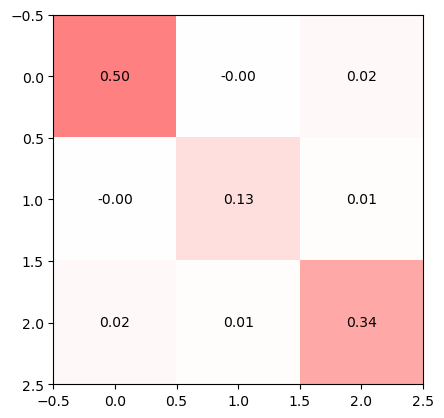

In [14]:
from PCMM.PCMMnumpy import Normal
from PCMM.mixture_EM_loop import mixture_EM_loop
model = Normal(p=3,K=1)
params,_,_ = mixture_EM_loop(data=data.T, model=model, max_iter=100, tol=1e-6,init='ls')
plt.imshow(params['Psi'][0], cmap='bwr', vmin=-1, vmax=1)
# add text to each field of the covariance matrix
for i in range(3):
    for j in range(3):
        plt.text(i, j, f'{params["Psi"][0][i,j]:.2f}', ha='center', va='center', color='black')

Waiting for a good least squares initialization
Found a good initialization
Initializing Psi based on the clustering centroids
Beginning EM loop


Loglik: -6654.09, relative change: 1.00e-06:  12%|█▏        | 12/100 [00:00<00:00, 671.84it/s]


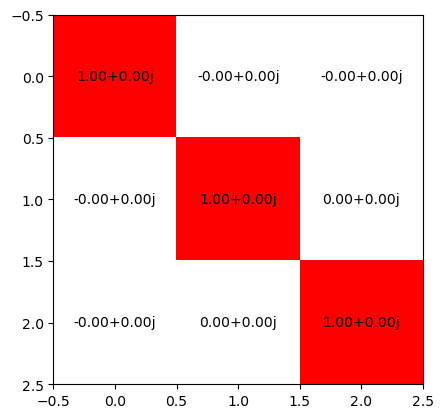

In [15]:
from scipy.signal import hilbert
analytic_signal = data + 1j * hilbert(data-np.mean(data, axis=1)[:,None])
analytic_signal = analytic_signal - np.mean(analytic_signal, axis=1)[:,None]
# analytic_signal_polar = np.abs(analytic_signal)*np.exp(1j*np.angle(analytic_signal))

from PCMM.PCMMnumpy import Normal
model = Normal(p=3,K=1,complex=True)
params,_,_ = mixture_EM_loop(data=analytic_signal.T, model=model, max_iter=100, tol=1e-6,init='ls')
plt.imshow(np.abs(params['Psi'][0]), cmap='bwr', vmin=-1, vmax=1)
# add text to each field of the covariance matrix
for i in range(3):
    for j in range(3):
        plt.text(i, j, f'{params["Psi"][0][i,j]:.2f}', ha='center', va='center', color='black')

Waiting for a good least squares initialization
Found a good initialization
Initializing Psi based on the clustering centroids
Beginning EM loop


Loglik: -2312.36, relative change: 1.97e-16:  12%|█▏        | 12/100 [00:00<00:00, 507.94it/s]


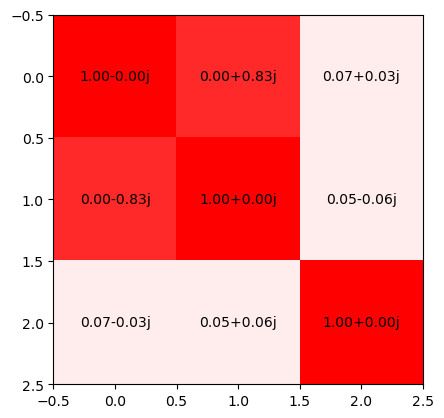

In [16]:
from scipy.signal import hilbert
analytic_signal = data + 1j * hilbert(data)
phase_data = np.exp(1j * np.angle(analytic_signal))/np.sqrt(3)

from PCMM.PCMMnumpy import ACG
model = ACG(p=3,K=1,complex=True)
params,_,_ = mixture_EM_loop(data=phase_data.T, model=model, max_iter=100, tol=1e-6,init='ls')
plt.imshow(np.abs(params['Psi'][0]), cmap='bwr', vmin=-1, vmax=1)
# add text to each field of the covariance matrix
for i in range(3):
    for j in range(3):
        plt.text(i, j, f'{params["Psi"][0][i,j]:.2f}', ha='center', va='center', color='black')